# Running Pipeline with ML Flow tracking server

This notebook demonstrates running through ML pipeline using a local ML Flow tracking server and tensorboard dashboarding.

More Info
* ML Flow tracking https://www.mlflow.org/docs/latest/tracking.html
* Tensorboard https://www.tensorflow.org/tensorboard

## Setting up tracking server

This notebook requires that a ML Flow tracking server b set up. In production, this would be pointing a proper roibust database server and a central storage area for artifacts, but we can demonstrate these concepts using a local machine. 

This notebook works with the `prd_ml` environment, which can be set up from `env/requirements_ml.yml` file. This includes mlflow and tensorboard. ML Flow has two parts to rteacking, a *backend store* and an *artifact store*. The backend store is where metrics, parameter values and paths etc are stored and links to all other elements of a particualr experiment and run. The artifact store is where objects are stored, such as saved trained models or plots. The bacend store will contain references to items in the artifact store related to particular run. The backend store is typically a database of some kind, and the artifact store is file system (e.g. local POSIX) or object store (e.g. cloud storage like AWS S3 or Azure Blob storage).


In this example we will use a local SQL Alchemy database for the backend store and a specified directory on the local filesystem for the artifact store. The backend database is just file, so it also specified as a path. To start up such an ML Flow server, activate the conda environment, then run the following ML Flow command from the command line to start your tracking server

`mlflow server --port $PORRT --backend-store-uri sqlite://<PATH TO DB>/<FILENAME>.db  --default-artifact-root $ARRTIFACT_PATH`

To Note
* This will only be accessible on your local machine. Yo make more widely accessible use the `--host 0.0.0.0` option
* when specifying the backend URI, if you specify a full path you will need FOUR slashes after the `sqlite:`, for example `sqlite:////user/name/experiments/my_project.db`, otherwise you will get an error.
* The artifact store can be a local file path e.g. `/path/to/artifacts/` or a remote object store like S3 e.g. `s3://project_bucket/project_key/`


### Import relevant libraries

In [1]:
import pathlib
import os
import datetime

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [3]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

In [4]:
%load_ext tensorboard

In [5]:
import tensorflow as tf
from tensorflow.keras.layers import Dense, Activation, Flatten
from tensorflow.keras.layers import Conv1D, concatenate
from tensorflow.keras.layers import ZeroPadding1D, Reshape, Input, Dropout, PReLU
from tensorflow.keras.models import Sequential, Model

from sklearn.metrics import mean_absolute_error, r2_score

In [6]:
import mlflow
mlflow.tensorflow.autolog()

### Load data

In [7]:
data_dir = pathlib.Path(os.environ['HOME']) / 'data' / 'precip_rediagnosis'

In [8]:
exp_track_dir = pathlib.Path(os.environ['HOME']) / 'experiment_tracking' / 'prd'

In [9]:
tensorboard_logs = exp_track_dir / 'logs'

In [10]:
dt_signature = datetime.datetime.now().strftime('%Y%m%d-%H%M%S')
dt_signature

'20220505-111611'

This server is running locally, but to share results, the ML Flow tracking server could be running on a shared server, writing to a shared disk space for the particular project .

In [11]:
mlflow_server_port = 5001
mlflow_server_uri = f'http://127.0.0.1:{mlflow_server_port:d}'
mlflow_server_uri

'http://127.0.0.1:5001'

In [28]:
prd_experiment_name = 'prd_exp1'

In [12]:
data = pd.read_csv(
    data_dir / 'prd_merged_015H_20200215T0300Z_20200217T0900Z.csv',
    index_col=0)

In [13]:
target_parameter = 'rainfall_rate_composite'
profile_features = ['air_temperature', 'relative_humidity']
single_lvl_features = ['air_pressure_at_sea_level'] 

### Data pre-processing

In [14]:
# drop NaN values in the dataset
data = data.dropna()

# drop data points with zero precip in the radar data
data = data[data[target_parameter]>0]

In [15]:
# Get a list of columns names for profile features
prof_feature_columns = [s for s in data.columns for vars in profile_features if s.startswith(vars)]

features = data[prof_feature_columns + single_lvl_features]

target = data[[target_parameter]]

In [16]:
# data_control uses only the control member

# data_control = data[data['realization']==0]

# # Get a list of columns names for profile features
# prof_feature_columns = [s for s in data.columns for vars in profile_features if s.startswith(vars)]

# features = data_control[prof_feature_columns + single_lvl_features]

# target = data_control[[target_parameter]]

In [17]:
features.describe().T

,count,mean,std,min,25%,50%,75%,max
air_temperature_5.0,153522.0,281.403148,2.469136,271.812500,279.875000,281.625000,283.250000,288.125000
air_temperature_10.0,153522.0,281.434214,2.473669,271.875000,279.937500,281.625000,283.312500,288.187500
air_temperature_20.0,153522.0,281.495603,2.488522,272.000000,280.000000,281.625000,283.375000,288.375000
air_temperature_30.0,153522.0,281.431163,2.492926,271.937500,279.875000,281.562500,283.312500,288.312500
air_temperature_50.0,153522.0,281.298198,2.511828,271.750000,279.750000,281.375000,283.250000,288.125000
...,...,...,...,...,...,...,...,...
relative_humidity_4500.0,153522.0,0.664071,0.258861,0.007812,0.489258,0.765625,0.875000,1.012695
relative_humidity_5000.0,153522.0,0.636342,0.267978,0.007812,0.461914,0.746094,0.852539,1.004883
relative_humidity_5500.0,153522.0,0.606278,0.274481,0.006836,0.412109,0.723633,0.829102,1.005859
relative_humidity_6000.0,153522.0,0.570755,0.278880,0.006836,0.343750,0.691406,0.802734,0.986328


In [18]:
standardScaler = StandardScaler()

features = pd.DataFrame(standardScaler.fit_transform(features), 
                                columns=features.columns,
                                index=features.index)
features.describe().T

,count,mean,std,min,25%,50%,75%,max
air_temperature_5.0,153522.0,-5.017796e-15,1.000003,-3.884224,-0.618902,0.089850,0.747977,2.722358
air_temperature_10.0,153522.0,-1.889819e-15,1.000003,-3.864399,-0.605060,0.077127,0.759314,2.730077
air_temperature_20.0,153522.0,8.673026e-15,1.000003,-3.815772,-0.601002,0.051998,0.755228,2.764459
air_temperature_30.0,153522.0,-9.964501e-15,1.000003,-3.808254,-0.624234,0.052684,0.754673,2.760355
air_temperature_50.0,153522.0,2.849539e-15,1.000003,-3.801307,-0.616365,0.030576,0.777047,2.717871
...,...,...,...,...,...,...,...,...
relative_humidity_4500.0,153522.0,-7.109037e-17,1.000003,-2.535187,-0.675321,0.392310,0.814836,1.346765
relative_humidity_5000.0,153522.0,-7.701457e-17,1.000003,-2.345456,-0.650905,0.409556,0.806773,1.375268
relative_humidity_5500.0,153522.0,-4.857842e-16,1.000003,-2.183918,-0.707405,0.427553,0.811802,1.455776
relative_humidity_6000.0,153522.0,3.080583e-16,1.000003,-2.022093,-0.813992,0.432628,0.831827,1.490154


In [19]:
processed_data = pd.concat([features, target], axis=1, sort=False)
processed_data

,air_temperature_5.0,air_temperature_10.0,air_temperature_20.0,air_temperature_30.0,air_temperature_50.0,air_temperature_75.0,air_temperature_100.0,air_temperature_150.0,air_temperature_200.0,air_temperature_250.0,...,relative_humidity_3250.0,relative_humidity_3500.0,relative_humidity_3750.0,relative_humidity_4000.0,relative_humidity_4500.0,relative_humidity_5000.0,relative_humidity_5500.0,relative_humidity_6000.0,air_pressure_at_sea_level,rainfall_rate_composite
0,0.950478,0.936178,0.905921,0.905099,0.926341,0.964120,0.998305,1.081785,1.155757,1.206579,...,0.016760,-0.611374,-0.999043,-1.364747,-1.169525,0.606342,0.783339,0.863343,1.602590,0.055013
1,0.899853,0.885645,0.855690,0.854957,0.876576,0.889926,0.900185,0.960767,1.036554,1.112492,...,-1.874734,-2.200925,-2.265530,-2.364876,-2.395603,-0.257332,0.804687,0.859841,1.582919,0.055013
2,1.152978,1.138307,1.106844,1.105667,1.075635,1.137240,1.194545,1.251211,1.298800,1.347711,...,-1.796249,-2.263722,-2.367793,-2.196227,-0.728136,0.792196,0.826034,0.894858,1.589476,0.055013
3,1.203604,1.188839,1.157075,1.155809,1.175165,1.186702,1.194545,1.251211,1.274959,1.300667,...,-0.301105,-1.255044,-1.600821,-1.513786,-0.535737,0.631852,0.772666,0.845834,1.585378,0.055013
4,0.798602,0.784580,0.755228,0.754673,0.777047,0.791000,0.802065,0.863952,0.893512,0.900795,...,-1.513702,-1.753496,-1.758148,-1.878539,-2.108889,0.478796,0.815360,0.908865,1.627998,0.055013
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
211387,-0.542964,-0.554528,-0.601002,-0.599163,-0.616365,-0.618689,-0.620674,-0.636677,-0.632279,-0.651651,...,-1.321413,-1.667150,-1.809280,-1.647136,-1.052576,-0.833115,-0.426334,-0.295734,-0.708723,0.486349
211388,-0.087338,-0.099736,-0.098695,-0.097742,-0.118718,-0.124061,-0.130074,-0.152603,-0.203150,-0.228257,...,-1.603960,-2.259797,-2.281263,-2.121707,-1.761815,-1.715010,-1.148580,-0.236204,-0.756261,0.486349
211389,-0.264526,-0.276600,-0.299618,-0.298310,-0.317777,-0.321912,-0.326314,-0.346233,-0.346193,-0.369388,...,-1.317489,-1.415962,-1.408095,-1.388280,-1.346834,-1.230332,-1.013381,-0.891030,-0.784947,0.486349
211390,-0.163276,-0.175535,-0.199156,-0.223097,-0.243130,-0.272449,-0.277254,-0.297825,-0.298512,-0.322345,...,-0.312878,-0.583901,-0.947911,-1.156877,-0.969579,-0.614463,-0.397871,-0.201187,-0.771833,0.486349


Split the dataset into 60/20/20 subsets for training, testing and validation

In [20]:
# Height profiles data
X_train_prof, X_test_prof, y_train, y_test = train_test_split(
    features[prof_feature_columns],
    target,
    test_size=0.2,
    random_state=1
)

# Single level data
X_train_singlvl, X_test_singlvl, y_train, y_test = train_test_split(
    features[single_lvl_features],
    target,
    test_size=0.2,
    random_state=1
)

# y_test and y_train is the same in both of these, given that the random state is set

In [21]:
# reshape height profile variables 
X_train_prof = np.transpose(X_train_prof.to_numpy().reshape(X_train_prof.shape[0], 2, 33), (0, 2, 1))
X_test_prof = np.transpose(X_test_prof.to_numpy().reshape(X_test_prof.shape[0], 2, 33), (0, 2, 1))

In [22]:
nprof_features = len(profile_features)
nheights = len(prof_feature_columns)//len(profile_features)
nsinglvl_features = len(single_lvl_features)

In [23]:
if nsinglvl_features > 0:
    X_train = [X_train_prof, X_train_singlvl]
    X_test = [X_test_prof, X_test_singlvl]
else:
    X_train = X_train_prof
    X_test = X_test_prof

## Set up model and experiment

In [24]:
def build_model(nprof_features, nheights, nsinglvl_features):
    
    profile_input = Input(shape=(nheights, nprof_features), name='profile_input')
    prof_size = nheights*nprof_features

    out = ZeroPadding1D(padding=1)(profile_input)
    out = Conv1D(32, 3, strides=1, activation='relu', use_bias=False, kernel_initializer='glorot_uniform', bias_initializer='zeros')(out)
    ident = out
    out = ZeroPadding1D(padding=1)(out)
    out = Conv1D(32, 3, strides=1, activation='relu', use_bias=False, kernel_initializer='glorot_uniform', bias_initializer='zeros')(out)
    out = ZeroPadding1D(padding=1)(out)
    out = Conv1D(32, 3, strides=1, activation='relu', use_bias=False, kernel_initializer='glorot_uniform', bias_initializer='zeros')(out)
    x = tf.keras.layers.add([out, ident])
    out = Flatten()(x)
    out = Dense(prof_size, use_bias=False, activation='relu')(out)

    if nsinglvl_features > 0:
        surf_input = Input(shape=(nsinglvl_features,), name='surf_input')
        flat_profs = Flatten()(profile_input)
        raw_in = tf.keras.layers.concatenate([flat_profs, surf_input])
        raw_size = (nheights*nprof_features)+nsinglvl_features
        
        out = tf.keras.layers.concatenate([out, surf_input])
        x = tf.keras.layers.add([out, raw_in])
        x = Dense(1024, use_bias=False, activation='relu')(x)
        x = Dense(1024, use_bias=False, activation='relu')(x)
        
        main_output = Dense(1, use_bias=True, activation='linear', name='main_output')(x)
        model = Model(inputs=[profile_input, surf_input], outputs=[main_output])
    
    else:
        main_output = Dense(1, use_bias=True, activation='linear', name='main_output')(out)
        model = Model(inputs=[profile_input], outputs=[main_output])
        
    return model

In [25]:
mlflow.set_tracking_uri(mlflow_server_uri)

[<Experiment: artifact_location='/Users/stephen.haddad/experiment_tracking/prd/0', experiment_id='0', lifecycle_stage='active', name='Default', tags={}>,
 <Experiment: artifact_location='/Users/stephen.haddad/experiment_tracking/prd/1', experiment_id='1', lifecycle_stage='active', name='prd_exp1', tags={}>]

In [31]:
try: 
    exp_id = mlflow.create_experiment(prd_experiment_name)
    exp1 = mlflow.get_experiment(exp_id)
except mlflow.exceptions.RestException:
    exp1 = mlflow.get_experiment_by_name(prd_experiment_name)
exp1

<Experiment: artifact_location='/Users/stephen.haddad/experiment_tracking/prd/1', experiment_id='1', lifecycle_stage='active', name='prd_exp1', tags={}>

### Launch tensorboard to track training
At this point we can start up tensor board to track the training of the model.

Like ml flow  this should be started from the command line
`tensorboard --logdir <PATH_TO_LOGS>`

The <PATH_TO_LOGS> is the same directory set earlier in the notebook as `tensorboard_logs`.

We will set up a callback so that our model traiining info gets sent to tensorboard to view through the server.

In [32]:
tensorflow_callback = tf.keras.callbacks.TensorBoard(log_dir=tensorboard_logs, histogram_freq=1)

## Run experiment

Here we actually run the training and evaluation. All parameters and the output model will be saved through ML Flow, and we can track training stats through tensorboard.

2022-05-05 11:19:18.448026: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
/Users/stephen.haddad/opt/anaconda3/envs/prd_ml/lib/python3.8/site-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 profile_input (InputLayer)     [(None, 33, 2)]      0           []                               
                                                                                                  
 zero_padding1d (ZeroPadding1D)  (None, 35, 2)       0           ['profile_input[0][0]']          
                                                                                                  
 conv1d (Conv1D)                (None, 33, 32)       192         ['zero_padding1d[0][0]']         
                                                                                                  
 zero_padding1d_1 (ZeroPadding1  (None, 35, 32)      0           ['conv1d[0][0]']                 
 D)                                                                                           

2022-05-05 11:19:40.926362: W tensorflow/python/util/util.cc:368] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


INFO:tensorflow:Assets written to: /var/folders/w0/2x361bn95wj7lfgl33vksx1w0000gn/T/tmpr2wuplw0/model/data/model/assets


2022/05/05 11:19:41 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "/Users/stephen.haddad/opt/anaconda3/envs/prd_ml/lib/python3.8/site-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument."
2022/05/05 11:19:41 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "/Users/stephen.haddad/opt/anaconda3/envs/prd_ml/lib/python3.8/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument."


MAE: 13.762
R-squared score: 0.365


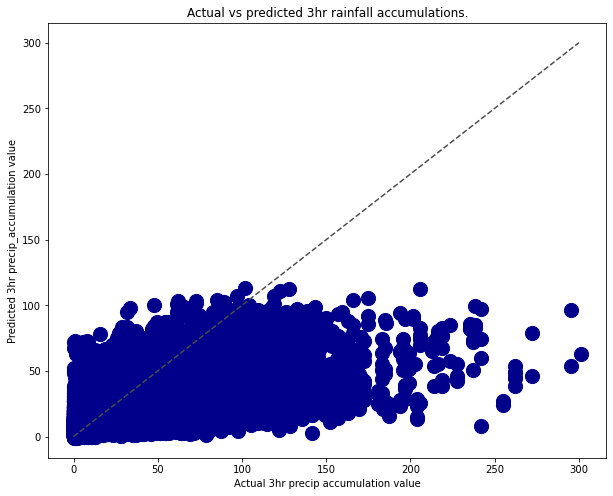

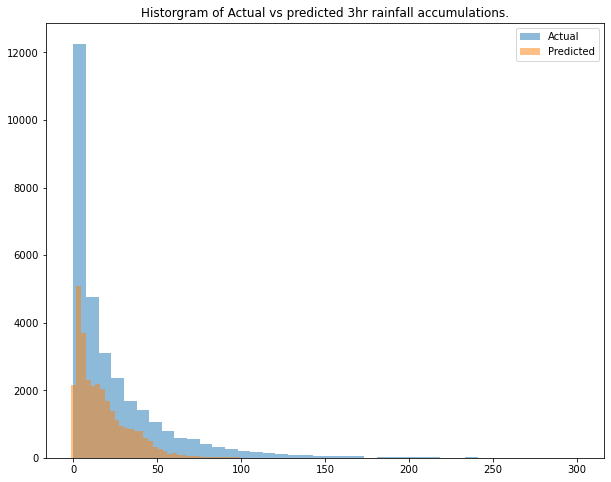

In [33]:
with mlflow.start_run(experiment_id=exp1.experiment_id, run_name='run1') as current_run:
    model = build_model(nprof_features, nheights, nsinglvl_features)
    model.summary()
    optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
    model.compile(loss='mean_absolute_error', optimizer=optimizer)

    history = model.fit(X_train, y_train, epochs=1, batch_size=32, validation_split=0.25, verbose=True, callbacks=[tensorflow_callback])

    y_pred = model.predict(X_test)
    error = mean_absolute_error(y_test, y_pred)
    print(f'MAE: {error:.3f}')
    rsqrd = r2_score(y_test, y_pred)
    print(f'R-squared score: {rsqrd:.3f}')
    
    mlflow.log_metric('MAE', error)
    mlflow.log_metric('R-squared', rsqrd)
    
    fig1 = plt.figure(figsize=(10, 8))
    ax1 = fig1.add_subplot(1,1,1, title='Actual vs predicted 3hr rainfall accumulations.')
    ax1.scatter(y_test, y_pred, s=200, c='darkblue')
    ax1.plot([0, 300], [0, 300], ls="--", c=".3")
    ax1.set_xlabel('Actual 3hr precip accumulation value')
    ax1.set_ylabel('Predicted 3hr precip_accumulation value')
    mlflow.log_figure(fig1, 'scatter_actual_vs_predicted_3hr_rainfall.png')
    
    fig1 = plt.figure(figsize=(10, 8))
    ax1 = fig1.add_subplot(1,1,1, title='Historgram of Actual vs predicted 3hr rainfall accumulations.')
    ax1.hist(y_test, alpha=0.5, bins=40, label='Actual')
    ax1.hist(y_pred, alpha=0.5, bins=40, label='Predicted')
    ax1.legend()
    mlflow.log_figure(fig1, 'hist_actual_vs_predicted_3hr_rainfall.png')
    
